In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from scipy import interp
import numpy as np
from itertools import cycle


In [2]:
def compute_best_point(fpr, tpr, thresholds):
    """
    Compute the nearest point to the left corner.
    :param fpr: False positive rate
    :param tpr: True positive rate
    :param thresholds: Threshold
    :return: sensitivity, specificity, threshold
    """
    dis = fpr ** 2 + (1 - tpr) ** 2
    best_index = np.argmin(dis)
    sensitivity = 1 - fpr[best_index]
    specificity = tpr[best_index]
    threshold = thresholds[best_index]
    return sensitivity, specificity, threshold

def _compute_roc_multi(y_true, y_pred, n_classes=5):
    """
    Compute ROC for multiclass
    :param y_true: true label
    :param y_pred: predict scores
    :param n_classes: num of classes
    :return: AUC of ROC, false positive rate, true positive rate
    """
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], thresholds = roc_curve(y_true[:, i], y_pred[:, i])
        sensitivity, specificity, threshold = compute_best_point(fpr[i], tpr[i], thresholds)
        print("{} sensitivity:{} specificity:{} threshold:{}".f)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    return roc_auc, fpr, tpr


def _plot_roc_multi(y_true, y_pred, n_classes=5):
    """
    Plot roc for multiclass
    :param y_true: true label
    :param y_pred: predict scores
    :param n_classes: num of classes
    :return: roc
    """
    roc_auc, fpr, tpr = _compute_roc_multi(y_true, y_pred, n_classes)
    lw = 2
    # Plot all ROC curves
    plt.figure(figsize=(8, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()


In [14]:
CLASS_NAMES = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
               'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
y_true = np.load('./result/{}.npz'.format('val_y_true'))['arr_0']
y_pred = np.load('./result/{}.npz'.format('val_y_pred'))['arr_0']


In [11]:
for i in range(len(CLASS_NAMES)):
    print('{}:{}'.format(CLASS_NAMES[i], roc_auc_score(y_true=y_true[:, i], y_score=y_pred[:, i])))


Atelectasis:0.8215911822722483
Cardiomegaly:0.9056551491879575
Effusion:0.8884551319026711
Infiltration:0.7085812369352036
Mass:0.7988335979824398
Nodule:0.6859748764141866
Pneumonia:0.669557754713439
Pneumothorax:0.8094865191980933
Consolidation:0.7825943310244257
Edema:0.879789846973272
Emphysema:0.8445161181091697
Fibrosis:0.7572422152297776
Pleural_Thickening:0.7634618275622408
Hernia:0.9279005612960837


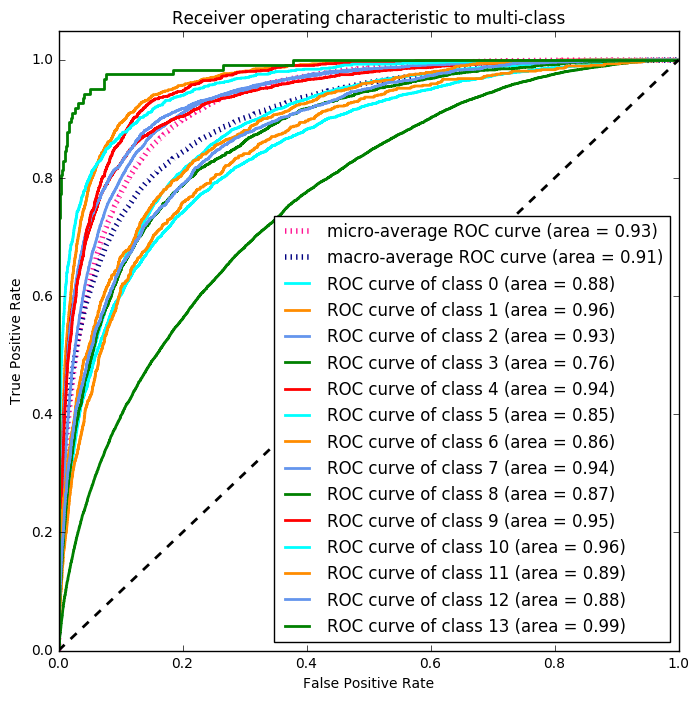

In [9]:
_plot_roc_multi(y_true=y_true, y_pred=y_pred, n_classes=14)
